##**Image Classification of Pet Breeds**

In [ ]:

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 26.7 MB/s 
     |████████████████████████████████| 346 kB 60.1 MB/s 
     |████████████████████████████████| 1.2 MB 50.2 MB/s 
     |████████████████████████████████| 4.2 MB 33.1 MB/s 
     |████████████████████████████████| 197 kB 58.4 MB/s 
     |████████████████████████████████| 60 kB 9.2 MB/s 
     |████████████████████████████████| 212 kB 75.5 MB/s 
     |████████████████████████████████| 1.1 MB 68.0 MB/s 
     |████████████████████████████████| 140 kB 71.5 MB/s 
     |████████████████████████████████| 86 kB 8.5 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
     |████████████████████████████████| 596 kB 68.7 MB/s 
     |████████████████████████████████| 127 kB 67.5 MB/s 
     |████████████████████████████████| 144 kB 10.7 MB/s 
     |████████████████████████████████| 94 kB 4.6 MB/s 
     |████████████████████████████████| 271 kB 71.9 MB/s 
     |████████████████████████████████| 112 kB 75.1 MB/s 
     |████████████████

In [ ]:

from fastbook import *

## Model 1: Classification of dogs and cats

Model to classify dogs and cats from the PETS dataset of fastai. 

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
path.ls()

(#2) [Path('annotations'),Path('images')]

Below ls command list all the file names

In [ ]:
(path/"images").ls()

(#7393) [Path('images/miniature_pinscher_76.jpg'),Path('images/havanese_110.jpg'),Path('images/basset_hound_30.jpg'),Path('images/Maine_Coon_135.jpg'),Path('images/Abyssinian_75.jpg'),Path('images/staffordshire_bull_terrier_163.jpg'),Path('images/leonberger_22.jpg'),Path('images/basset_hound_162.jpg'),Path('images/Bombay_185.jpg'),Path('images/Maine_Coon_96.jpg')...]

The file names contain pet breeds in a particular structured format. If we extract the names from the file names using regular expression, it can help us analyze pet breeds together. 

In [ ]:
fname = (path/"images").ls()[0]

In [ ]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['miniature_pinscher']

Datablock is a function that can help get data into dataloaders for example: image block and category block. Below code shows the datablock used to load the pets data into dataloaders. It also helps us apply methods on batch as well as individual items. 



In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

## Presizing

Presizing helps in getting all the images from the dataset to the same dimentions, which can be further fed into the GPU for analysis. The first step, the resize, creates images large enough that they have spare margin to allow further augmentation transforms on their inner regions without creating empty zones. This transformation works by resizing to a square, using a large crop size. On the training set, the crop area is chosen randomly, and the size of the crop is selected to cover the entire width or height of the image, whichever is smaller. In the second step, the GPU is used for all data augmentation, and all of the potentially destructive operations are done together, with a single interpolation at the end. This is done mainly to speed up the excution of models.

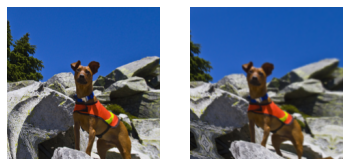

In [ ]:

#caption A comparison of fastai's data augmentation strategy (left) and the traditional approach (right).
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(path/'images'/'miniature_pinscher_76.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

### Checking and Debugging a DataBlock

After presizing the image, the datablock need to be further checked to see if the images make sense. By executing 'show_batch' of the datablock, we will get an error message if there are any. This helps to make sure we have a valid data source before training the model. 

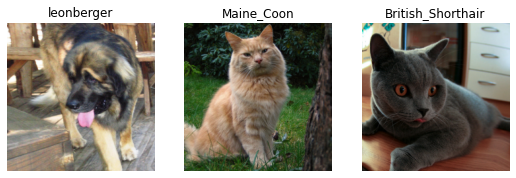

In [ ]:
dls.show_batch(nrows=1, ncols=3)

In [ ]:
#hide_output
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))


```
Setting-up type transforms pipelines
Collecting items from /home/sgugger/.fastai/data/oxford-iiit-pet/images
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/sgugger/.fastai/data/oxford-iiit-pet/images/american_bulldog_83.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: partial -> Categorize
    starting from
      /home/sgugger/.fastai/data/oxford-iiit-pet/images/american_bulldog_83.jpg
    applying partial gives
      american_bulldog
    applying Categorize gives
      TensorCategory(12)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(12))

Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=375x500, TensorCategory(12))
    applying ToTensor gives
      (TensorImage of size 3x500x375, TensorCategory(12))

Adding the next 3 samples

No before_batch transform to apply

Collating items in a batch
Error! It's not possible to collate your items in a batch
Could not collate the 0-th members of your tuples because got the following 
shapes:
torch.Size([3, 500, 375]),torch.Size([3, 375, 500]),torch.Size([3, 333, 500]),
torch.Size([3, 375, 500])
```

Using CNN Learner, the initial model is trained. An epoch is one complete pass through all the images. The table shows the results after each epoch such as train_loss, vaid_loss, error_rate and the time it took for implementation. Resnet34 is a 34 layer convolutional neural network that can be utilized as a state-of-the-art image classification model. This is a model that has been pre-trained on the ImageNet dataset--a dataset that has 100,000+ images across 200 different classes. 

For the dataset used, Resnet34 will be an untrained pretrained model. Hence we use Fine_tune to only train the last layer of the neural network first and then unfreeze all the layers and train the model again. 

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.510803,0.365868,0.112991,01:12


epoch,train_loss,valid_loss,error_rate,time
0,0.494624,0.293602,0.089986,01:17
1,0.317144,0.235874,0.075101,01:18


Above output shows higher train_loss as compared to valid_loss. This is the case as we are only training the last network layer at this point. 

Didiving the data into x,y forms a tuple, which showcase dependent and independent variables below.

In [ ]:
x,y = dls.one_batch()

There are 64 data elements - one of 37 breeds is represented by each value. 

In [ ]:
y

TensorCategory([ 8, 30, 30,  0, 20, 19,  2, 25,  8, 23,  4, 23,  7,  7,  8, 13, 34,  3, 13, 35,  6, 19, 21,  2, 35,  4, 29, 34, 21, 35, 16,  6, 12, 14,  3,  7, 26, 10,  3, 10, 32,  9, 12, 23, 18,  5,  9, 24,
        14, 11, 36, 34, 30, 34,  3, 15, 10, 15, 12, 20,  9, 17, 14, 31], device='cuda:0')

The predictions (that is, the activations of the final layer of our neural network) can be seen using `Learner.get_preds`. This function either takes a dataset index (0 for train and 1 for valid) or an iterator of batches. 

In [ ]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

TensorBase([6.5901e-05, 2.8313e-06, 4.2225e-01, 1.4707e-04, 4.7082e-06, 1.1643e-05, 5.2711e-04, 6.4989e-05, 5.6757e-01, 8.0376e-07, 8.9307e-03, 1.3148e-05, 2.7113e-06, 4.3723e-06, 8.4599e-06, 5.8818e-06,
        6.2031e-06, 3.3565e-06, 1.1901e-06, 6.6065e-06, 2.2762e-06, 3.6064e-05, 1.1043e-06, 1.3092e-05, 1.1489e-06, 1.8302e-04, 7.0714e-07, 7.9212e-07, 4.8840e-06, 6.8456e-06, 8.8684e-05, 8.3288e-06,
        6.5315e-07, 1.4600e-05, 2.9781e-06, 1.6366e-06, 4.9866e-06])

The actual predictions are 37 probabilities between 0 and 1, which add up to 1 in total:

In [ ]:
len(preds[0]),preds[0].sum()

(37, TensorBase(1.))

*Softmax* activation function is used to transform the activations of our model into predictions like this.

### Softmax

In our classification model, we use the softmax activation function in the final layer to ensure that the activations are all between 0 and 1, and that they sum to 1.
Softmax is used to interpret the model results and classify the images into respective classes. 

Sigmoid function also does the same. 

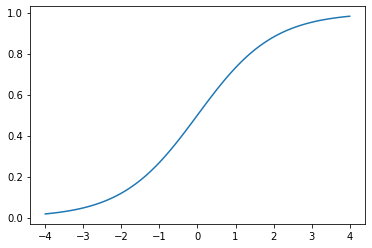

In [ ]:
plot_function(torch.sigmoid, min=-4,max=4)

In [ ]:
#hide
torch.random.manual_seed(42);

In [ ]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [ ]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [ ]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

Let's check that `softmax` returns the same values as `sigmoid` for the first column, and those values subtracted from 1 for the second column:

In [ ]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log Likelihood

In [ ]:
targ = tensor([0,1,0,1,1,0])

In [ ]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [ ]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [ ]:
#hide_input
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = -sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,-0.602469
0.502065,0.497935,1,1,-0.497935
0.133188,0.866811,0,2,-0.133188
0.996640,0.003360,1,3,-0.003360
0.595949,0.404051,1,4,-0.404051
0.366118,0.633882,0,5,-0.366118


In [ ]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [ ]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### Taking the Log

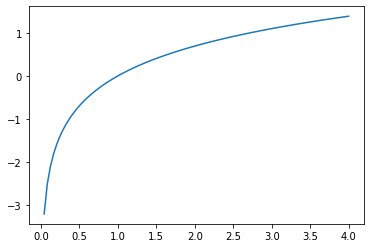

In [ ]:
plot_function(torch.log, min=0,max=4)

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
loss_func(acts, targ)

tensor(1.8045)

In [ ]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

Confusion matrix of actual and predicted values. A strong diagonal line represents a good model.

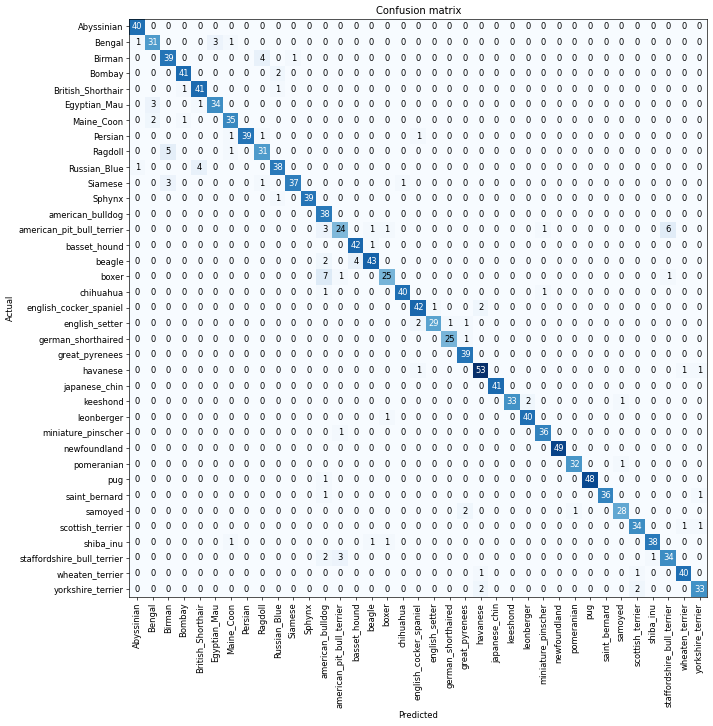

In [ ]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

The command `most_confused` method shows the breeds that have least correct predictions.

In [ ]:
interp.most_confused(min_val=5)

[('boxer', 'american_bulldog', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Ragdoll', 'Birman', 5)]

### The Learning Rate Finder

Training a model is to make sure that we have the right learning rate is one of the most important steps. 

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,2.770597,6.657153,0.554804,01:11


epoch,train_loss,valid_loss,error_rate,time
0,3.567321,2.758865,0.576455,01:18


The above results are not great. The optimizer stepped in the correct direction, but it stepped so far that it totally overshot the minimum loss. Repeating that multiple times makes it get further and further away.*Learning rate finder* helps find the optimal learning rate. 

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
#lr_min,lr_steep = learn.lr_find()
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.496993,0.354354,0.115020,01:12


epoch,train_loss,valid_loss,error_rate,time
0,0.532815,0.325653,0.104195,01:18
1,0.328292,0.244836,0.076455,01:17


In [ ]:
#print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In this learning rate plot it appears that a learning rate around 3e-3 would be appropriate.

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.313824,0.333416,0.100135,01:13


epoch,train_loss,valid_loss,error_rate,time
0,0.535482,0.447883,0.121110,01:19
1,0.331782,0.259990,0.079838,01:18


In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(12, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.322011,0.354919,0.116373,01:12


epoch,train_loss,valid_loss,error_rate,time
0,0.420290,0.271378,0.078484,01:19
1,0.357341,0.324394,0.101489,01:18
2,0.346669,0.392237,0.112991,01:18
3,0.329790,0.482459,0.115020,01:20
4,0.274542,0.379915,0.100135,01:19
5,0.202873,0.304664,0.082544,01:19
6,0.154093,0.321207,0.075101,01:20
7,0.106817,0.292882,0.072395,01:18
8,0.066862,0.240194,0.063599,01:20
9,0.049111,0.229763,0.059540,01:19


> Note: Logarithmic Scale: The learning rate finder plot has a logarithmic scale, which is why the middle point between 1e-3 and 1e-2 is between 3e-3 and 4e-3. This is because we care mostly about the order of magnitude of the learning rate.

### Unfreezing and Transfer Learning

In this section fine tuning of the model can be seen. We now know that a convolutional neural network consists of many linear layers with a nonlinear activation function between each pair, followed by one or more final linear layers with an activation function such as softmax at the very end. The final linear layer uses a matrix with enough columns such that the output size is the same as the number of classes in our model (assuming that we are doing classification).

This final linear layer is unlikely to be of any use for us when we are fine-tuning in a transfer learning setting, because it is specifically designed to classify the categories in the original pretraining dataset. So when we do transfer learning we remove it, throw it away, and replace it with a new linear layer with the correct number of outputs for our desired task (in this case, there would be 37 activations).

This newly added linear layer will have entirely random weights. Therefore, our model prior to fine-tuning has entirely random outputs. But that does not mean that it is an entirely random model! All of the layers prior to the last one have been carefully trained to be good at image classification tasks in general. 

Our challenge when fine-tuning is to replace the random weights in our added linear layers with weights that correctly achieve our desired task (classifying pet breeds) without breaking the carefully pretrained weights and the other layers. There is actually a very simple trick to allow this to happen: tell the optimizer to only update the weights in those randomly added final layers. Don't change the weights in the rest of the neural network at all. This is called *freezing* those pretrained layers.

In [ ]:
learn.fine_tune??

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.130822,0.327178,0.102842,01:11
1,0.535939,0.275542,0.083221,01:12
2,0.324671,0.228628,0.073072,01:11


Then we'll unfreeze the model:

In [ ]:
learn.unfreeze()

SuggestedLRs(valley=6.918309736647643e-06)

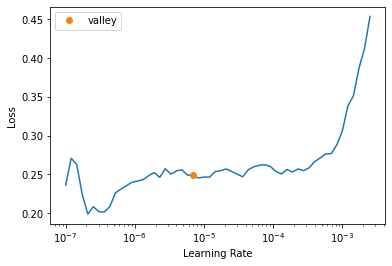

In [ ]:
learn.lr_find()

Note that the graph is a little different from when we had random weights. That's because our model has been trained already. Here we have a somewhat flat area before a sharp increase, and we should take a point well before that sharp increase—for instance, 1e-5. The point with the maximum gradient isn't what we look for here and should be ignored.

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.269124,0.219017,0.069012,01:18
1,0.241890,0.210188,0.069012,01:17
2,0.218036,0.201540,0.062923,01:16
3,0.208110,0.196639,0.063599,01:16
4,0.189551,0.192281,0.060893,01:18
5,0.194557,0.195296,0.061570,01:17


This has improved our model a bit, but there's more we can do. The deepest layers of our pretrained model might not need as high a learning rate as the last ones, so we should probably use different learning rates for those—this is known as using *discriminative learning rates*.

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.137636,0.313939,0.102165,01:10
1,0.515430,0.250352,0.077808,01:12
2,0.333047,0.225056,0.076455,01:11


epoch,train_loss,valid_loss,error_rate,time
0,0.255987,0.221536,0.075778,01:17
1,0.249402,0.215091,0.076455,01:16
2,0.232085,0.203588,0.068336,01:18
3,0.202703,0.208343,0.072395,01:18
4,0.187589,0.198972,0.069012,01:16
5,0.173300,0.197377,0.062923,01:17
6,0.160320,0.201523,0.065629,01:18
7,0.143303,0.192343,0.064953,01:17
8,0.130346,0.189163,0.060217,01:17
9,0.133731,0.192382,0.065629,01:19


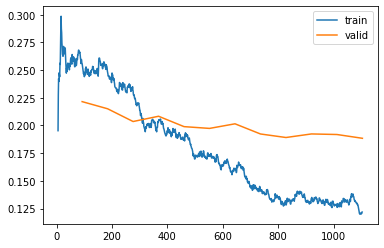

In [ ]:
learn.recorder.plot_loss()

As you can see, the training loss keeps getting better and better. But notice that eventually the validation loss improvement slows, and sometimes even gets worse! This is the point at which the model is starting to over fit. In particular, the model is becoming overconfident of its predictions. But this does *not* mean that it is getting less accurate, necessarily. Take a look at the table of training results per epoch, and you will often see that the accuracy continues improving, even as the validation loss gets worse. In the end what matters is your accuracy, or more generally your chosen metrics, not the loss. The loss is just the function we've given the computer to help us to optimize.

Another decision you have to make when training the model is for how long to train for. We'll consider that next.

In [ ]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.285239,0.322151,0.097429,01:09
1,0.561403,0.286511,0.087957,01:10
2,0.435244,0.247878,0.072395,01:08


epoch,train_loss,valid_loss,error_rate,time
0,0.273634,0.293867,0.087957,01:10
1,0.323046,0.382261,0.099459,01:10
2,0.264868,0.290997,0.079161,01:12
3,0.149150,0.231733,0.064276,01:10
4,0.087425,0.211095,0.054804,01:10
5,0.056023,0.201772,0.059540,01:10


You'll see here we've gone back to using `fine_tune`, since it's so handy! We can pass `freeze_epochs` to tell fastai how many epochs to train for while frozen. It will automatically change learning rates appropriately for most datasets.

In this case, we're not seeing a clear win from the deeper model. This is useful to remember—bigger models aren't necessarily better models for your particular case! Make sure you try small models before you start scaling up.